# London Crimes

In [12]:
import numpy as np
import pandas as pd
import bq_helper
from datetime import datetime
from ggplot import *
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%%bash
export GOOGLE_APPLICATION_CREDENTIALS="/home/tpin3694/Documents/phd-hours-81c4006f26e7.json"

## Load the BigQuery dataset

In [3]:
london = bq_helper.BigQueryHelper(active_project="bigquery-public-data", dataset_name="london_crime")
london.list_tables()

['crime_by_lsoa']

There's only a single table which we can inspect to see what data is contained within the table.

In [4]:
london.head('crime_by_lsoa')

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01032740,City of London,Violence Against the Person,Harassment,0,2016,11
1,E01000005,City of London,Violence Against the Person,Harassment,0,2011,3
2,E01032739,City of London,Violence Against the Person,Harassment,0,2016,12
3,E01000005,City of London,Violence Against the Person,Harassment,0,2011,11
4,E01000005,City of London,Violence Against the Person,Harassment,0,2014,3


Clearly we're dealing with spatiotemporal data here. Spatially, we can be happy that we're dealing with locations strictly within the London area, aggregated to the LSOA area. It is of interest to examine the temporal range we're dealing with as since 2011, the LSOA boundaries changed slightly.

In [5]:
min_max = """
SELECT MIN(year) AS minyear, MIN(month) AS minmonth, MAX(year) AS maxyear, MAX(month) AS maxmonth
FROM `bigquery-public-data.london_crime.crime_by_lsoa`
"""

mins = london.query_to_pandas(min_max)
print(mins)

   minyear  minmonth  maxyear  maxmonth
0     2008         1     2016        12


## Investigating Crimes by Borough

Lets first look at the number of crimes per borough. We will not focus on individual crimes here, instead just looking at raw counts.

In [6]:
crimes_borough_query = """
SELECT borough, year, month, sum(value) AS `total_count`
FROM `bigquery-public-data.london_crime.crime_by_lsoa`
WHERE year > 2010
GROUP BY borough, year, month;
"""

borough_counts = london.query_to_pandas_safe(crimes_borough_query).sort_values(by=['year',
                                                                                   'month',
                                                                                   'borough']).reset_index(drop=True)
borough_counts.head()

,borough,year,month,total_count
0,Barking and Dagenham,2011,1,1314
1,Barnet,2011,1,1995
2,Bexley,2011,1,996
3,Brent,2011,1,2142
4,Bromley,2011,1,1682


### Plotting This Data Through Time

In [7]:
borough_counts['norm_counts'] = (borough_counts.total_count - borough_counts.total_count.min())/(borough_counts.total_count.max()-borough_counts.total_count.min())

In [8]:
borough_counts['day'] = 1
borough_counts['date'] = pd.to_datetime(borough_counts[['year', 'month', 'day']])

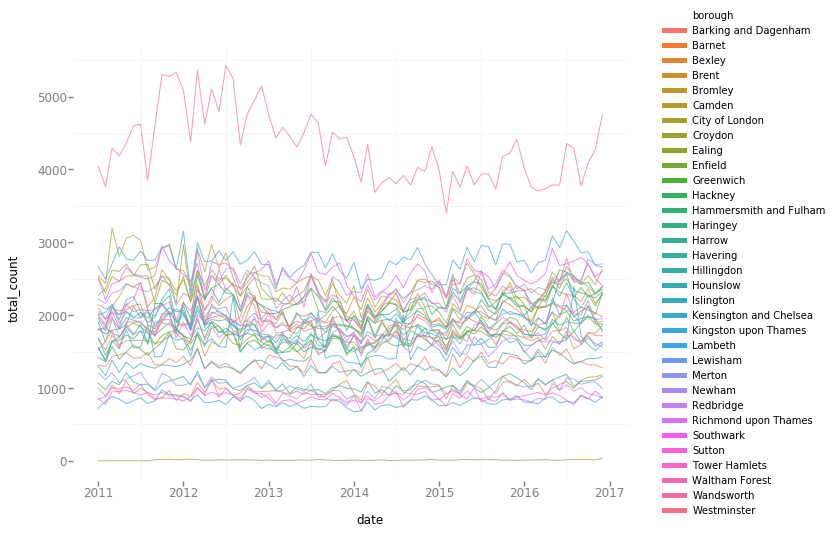

<ggplot: (8747420950648)>

In [9]:
ggplot(aes(x='date', y='total_count', colour='borough'), data=borough_counts) +\
geom_line(alpha=0.7, size=1) +\
theme_bw()

## Going Down to the LSOA level
LSOA polygons are significantly smaller than boroughs, and therefore can provide more detailed inference. To do anything with this information, we first need to pull in the LSOA boundaries; a task we can do by downloading the LSOA shapefile.

In [ ]:
%%bash
wget -cO - https://opendata.arcgis.com/datasets/90e15daaaeef4baa877f4bffe01ebef0_0.zip?outSR=%7B%22wkid%22%3A27700%2C%22latestWkid%22%3A27700%7D > data/lsoas.zip
unzip data/lsoas.zip -d data/

In [10]:
lsoa_shp = gpd.read_file('data/Lower_Layer_Super_Output_Areas_December_2001_Full_Clipped_Boundaries_in_England_and_Wales.shp')

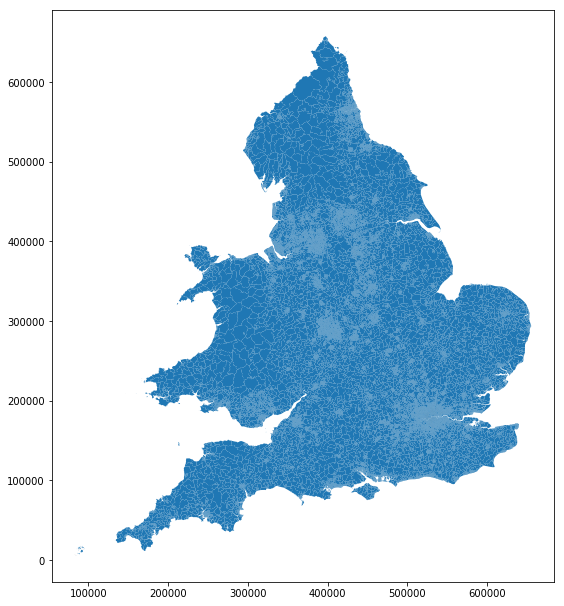

In [15]:
lsoa_shp.plot(figsize=(9, 12))

In [16]:
lsoa_shp.head()

,objectid,lsoa01cd,lsoa01nm,lsoa01nmw,st_areasha,st_lengths,geometry
0,1,E01000001,City of London 001A,City of London 001A,1.298652e+05,2635.780444,"POLYGON ((532151.5504999999 181867.3959999997,..."
1,2,E01000002,City of London 001B,City of London 001B,2.284190e+05,2708.016924,"POLYGON ((532634.4941999996 181926.0011999998,..."
2,3,E01000003,City of London 001C,City of London 001C,5.905396e+04,1224.808785,"POLYGON ((532153.7024999997 182165.1550999992,..."
3,4,E01000004,City of London 001D,City of London 001D,2.290913e+06,10365.345411,"POLYGON ((533383.4859999996 181914.3707999997,..."
4,5,E01000005,City of London 001E,City of London 001E,1.895772e+05,2275.835227,"POLYGON ((533619.0617000004 181402.3637000006,..."


In [26]:
crimes_lsoa_query = """
SELECT lsoa_code, sum(value) AS `total_count`
FROM `bigquery-public-data.london_crime.crime_by_lsoa`
WHERE year > 2010
GROUP BY lsoa_code;
"""

lsoa_counts = london.query_to_pandas_safe(crimes_borough_query).sort_values(by=['lsoa_code']).reset_index(drop=True)

In [34]:
all_data = gpd.GeoDataFrame(pd.merge(lsoa_counts, lsoa_shp, how='left', right_on='lsoa01cd', left_on='lsoa_code'))
all_data['log_total_count'] = np.log(all_data.total_count+0.1)

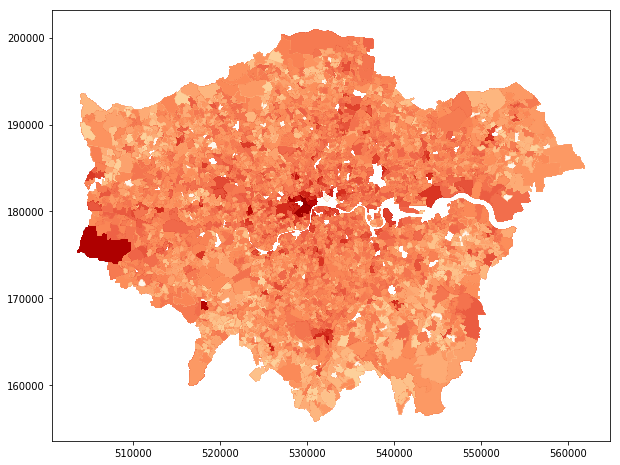

In [41]:
all_data.plot(column='log_total_count', cmap='OrRd', figsize=(10, 11))

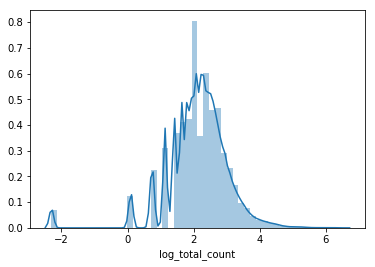

In [35]:
import seaborn as sns

sns.distplot(all_data.log_total_count)